In [37]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
# 加载LibSVM格式数据模块
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

!pwd
!ls -a ./raw

/home/www/project/jupyter_projects/ReturnToHome
.  ..  dataA.csv  dataNoLabel.csv  dataTrain.csv  submit_example_A.csv


In [2]:
!pip3 install sklearn

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [25]:
raw_data = pd.read_csv("./raw/dataTrain.csv")

raw_data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f38,f39,f40,f41,f42,f43,f44,f45,f46,label
0,81167,0,1,mid,0,0,0,153,0,0,...,0,0,0,0,0,0,0,624,1539,0
1,50408,1,1,mid,0,0,21,0,0,0,...,0,0,0,0,0,0,0,186,366,0
2,9114,0,0,high,36,36,120,0,0,0,...,0,0,0,0,0,0,0,24,48,1
3,53228,1,1,low,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,9,0
4,56280,1,1,mid,9,51,294,0,0,0,...,0,0,0,0,0,0,0,42,141,0


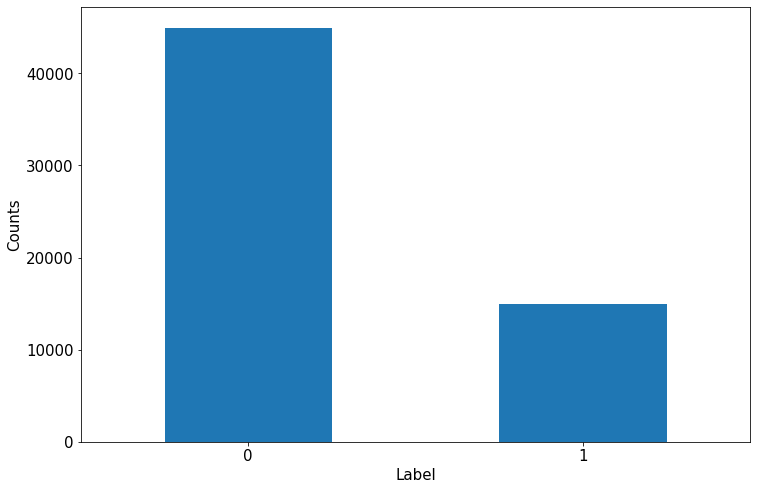

In [33]:
# label 分布情况
ax = raw_data['label'].value_counts().plot(kind = 'bar',figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Label',fontsize = 15)
plt.show()

In [ ]:
def data_pre_process(raw,is_train=True):
    data = raw.copy()
    data["f3"] = raw["f3"].map({'low': 0, 'mid': 1, 'high': 2})
    label = None
    
    # 暴力Feature 位置
    loc_f = ['f1', 'f2', 'f4', 'f5', 'f6']
    for i in range(len(loc_f)):
        for j in range(i + 1, len(loc_f)):
            data[f'{loc_f[i]}+{loc_f[j]}'] = data[loc_f[i]] + data[loc_f[j]]
            data[f'{loc_f[i]}-{loc_f[j]}'] = data[loc_f[i]] - data[loc_f[j]]
            data[f'{loc_f[i]}*{loc_f[j]}'] = data[loc_f[i]] * data[loc_f[j]]
            data[f'{loc_f[i]}/{loc_f[j]}'] = data[loc_f[i]] / data[loc_f[j]]
            
    # 暴力Feature 通话
    com_f = ['f43', 'f44', 'f45', 'f46']
    for i in range(len(com_f)):
        for j in range(i + 1, len(com_f)):
            data[f'{com_f[i]}+{com_f[j]}'] = data[com_f[i]] + data[com_f[j]]
            data[f'{com_f[i]}-{com_f[j]}'] = data[com_f[i]] - data[com_f[j]]
            data[f'{com_f[i]}*{com_f[j]}'] = data[com_f[i]] * data[com_f[j]]
            data[f'{com_f[i]}/{com_f[j]}'] = data[com_f[i]] / data[com_f[j]]
            
    # 离散化            
    all_f = [f'f{idx}' for idx in range(1, 47) if idx != 3]
    for col in all_f:
        data[f'{col}_log'] = data[col].apply(lambda x: int(np.log(x)) if x > 0 else 0)

    # 特征交叉        
    log_f = [f'f{idx}_log' for idx in range(1, 47) if idx != 3]
    for i in range(len(log_f)):
        for j in range(i + 1, len(log_f)):
            data[f'{log_f[i]}_{log_f[j]}'] = data[log_f[i]]*10000 + data[log_f[j]]
    
    data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    if is_train:
        label = data["label"]
        del data["label"]
    del data["id"]
    
    return data,label

data,data_label = data_pre_process(raw_data)
data = data[:50000]
data_label = data_label[:50000]

data.describe()

In [ ]:
#分类器使用 xgboost
clf1 = xgb.XGBClassifier(learning_rate=0.1,
                      n_estimators=100,            # 树的个数--100棵树建立xgboost
                      max_depth=6,                 # 树的深度
                      min_child_weight = 1,        # 叶子节点最小权重
                      gamma=0.,                    # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,               # 随机选择80%样本建立决策树
                      colsample_btree=0.8,         # 随机选择80%特征建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,          # 解决样本个数不平衡的问题
                      random_state=27              # 随机数
                      )
 
#设定搜索的xgboost参数搜索范围，值搜索XGBoost的主要6个参数
param_dist = {
'n_estimators':range(80,200,4),
'max_depth':range(2,15,1),
'learning_rate':np.linspace(0.01,2,20),
'subsample':np.linspace(0.7,0.9,20),
'colsample_bytree':np.linspace(0.5,0.98,10),
'min_child_weight':range(1,9,1)
}
 
#RandomizedSearchCV参数说明，clf1设置训练的学习器
#param_dist字典类型，放入参数搜索范围
#scoring = 'neg_log_loss'，精度评价方式设定为“neg_log_loss“
#n_iter=300，训练300次，数值越大，获得的参数精度越大，但是搜索时间越长
#n_jobs = -1，使用所有的CPU进行训练，默认为1，使用1个CPU
grid = RandomizedSearchCV(clf1,param_dist,cv = 3,scoring = 'auc',n_iter=300,n_jobs = -1)
 
'''
#在训练集上训练
grid.fit(data,data_label) #TODO : 这里把训练停了
#返回最优的训练器
best_estimator = grid.best_estimator_
print(best_estimator)
#输出最优训练器的精度
print(grid.best_score_)
'''

In [17]:
def train_model(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2,random_state = 33)
    ### 训练模型
    model = xgb.XGBClassifier(learning_rate=0.1,
                      n_estimators=100,            # 树的个数--100棵树建立xgboost
                      max_depth=6,                 # 树的深度
                      min_child_weight = 1,        # 叶子节点最小权重
                      gamma=0.,                    # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,               # 随机选择80%样本建立决策树
                      colsample_btree=0.8,         # 随机选择80%特征建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,          # 解决样本个数不平衡的问题
                      random_state=27              # 随机数
                      )
    
    # 拟合
    model.fit(x_train, y_train, eval_set = [(x_test,y_test)], eval_metric = "auc", early_stopping_rounds = 10,verbose = True)
    return model,x_train,x_test,y_train,y_test

model,x_train,x_test,y_train,y_test = train_model(data,data_label)
model

/usr/local/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:22:45] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_btree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.89705
[1]	validation_0-auc:0.89870
[2]	validation_0-auc:0.89993
[3]	validation_0-auc:0.90165
[4]	validation_0-auc:0.90189
[5]	validation_0-auc:0.90337
[6]	validation_0-auc:0.90362
[7]	validation_0-auc:0.90476
[8]	validation_0-auc:0.90465
[9]	validation_0-auc:0.90501
[10]	validation_0-auc:0.90477
[11]	validation_0-auc:0.90513
[12]	validation_0-auc:0.90513
[13]	validation_0-auc:0.90501
[14]	validation_0-auc:0.90521
[15]	validation_0-auc:0.90547
[16]	validation_0-auc:0.90538
[17]	validation_0-auc:0.90549
[18]	validation_0-auc:0.90554
[19]	validation_0-auc:0.90554
[20]	validation_0-auc:0.90561
[21]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=0.8,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [18]:
# 查看训练模型准确度
def show_auc(x,y,model):
    pred_label = model.predict(x)
    pred_prob = model.predict_proba(x)
    acc = accuracy_score(y, pred_label)
    precision = precision_score(y, pred_label)
    recall = recall_score(y, pred_label)
    auc = roc_auc_score(y, pred_label) # 标签计算
    fpr,tpr,threshold=roc_curve(y,pred_prob[:,1],pos_label=1)
    auc_all = roc_auc_score(y, pred_prob[:,1]) # 按概率计算
    print("===="*8)
    print("Summary:")
    print(f"acc: {acc}\nrecall: {recall}\nauc: {auc}\nfull_auc: {auc_all}")
    print("===="*8)
    print()

show_auc(x_train, y_train, model)
show_auc(x_test, y_test, model)
show_auc(data,data_label,model)

Summary:
acc: 0.881575
recall: 0.6376622070214264
auc: 0.799951566599971
full_auc: 0.926520247028244

Summary:
acc: 0.8628
recall: 0.6006326611308818
auc: 0.7760893194558169
full_auc: 0.9072876966897547

Summary:
acc: 0.87782
recall: 0.6301523656776263
auc: 0.7951321380746245
full_auc: 0.9226638352509653



In [19]:
# 半监督
raw_semi = pd.read_csv("./raw/dataNoLabel.csv")
data_semi,_ = data_pre_process(raw_semi,is_train=False)

pred_label_semi = model.predict(data_semi)
# data_semi["label"] = pred_label_semi

data_semi

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f43*f46,f44+f45,f44-f45,f44*f45,f44+f46,f44-f46,f44*f46,f45+f46,f45-f46,f45*f46
0,0,1,1,0,0,0,0,0,0,0,...,0,171,-135,2754,522,-486,9072,657,-351,77112
1,1,1,1,0,0,0,0,0,0,0,...,24786,720,-594,41391,1440,-1314,86751,2034,-720,904689
2,0,1,0,0,0,0,0,0,0,0,...,0,54,-54,0,81,-81,0,135,-27,4374
3,1,1,1,0,0,0,0,0,0,0,...,0,27,-27,0,27,-27,0,54,0,729
4,1,1,0,0,0,0,0,0,0,0,...,0,234,-234,0,729,-729,0,963,-495,170586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39879,0,0,1,0,0,54,0,0,0,0,...,23895,342,-108,26325,648,-414,62127,756,-306,119475
39880,0,1,0,144,198,594,0,0,0,0,...,753786,2151,-1503,591948,4977,-4329,1507572,6480,-2826,8501031
39881,0,1,0,0,0,0,0,0,0,0,...,17496,891,-873,7938,1953,-1935,17496,2826,-1062,1714608
39882,0,1,0,0,0,0,0,0,0,0,...,0,189,-189,0,459,-459,0,648,-270,86751


In [20]:
# 加入之后重新训练
data_semi_concat = pd.concat([data, data_semi]).reset_index(drop=True)
label_semi_concat = np.append(data_label,pred_label_semi)

model_semi,x_semi_train,x_semi_test,y_semi_train,y_semi_test = train_model(data_semi_concat,label_semi_concat)

/usr/local/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:20] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_btree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.92932
[1]	validation_0-auc:0.93198
[2]	validation_0-auc:0.93234
[3]	validation_0-auc:0.93292
[4]	validation_0-auc:0.93362
[5]	validation_0-auc:0.93438
[6]	validation_0-auc:0.93640
[7]	validation_0-auc:0.93663
[8]	validation_0-auc:0.93812
[9]	validation_0-auc:0.93841
[10]	validation_0-auc:0.93933
[11]	validation_0-auc:0.93963
[12]	validation_0-auc:0.93994
[13]	validation_0-auc:0.94031
[14]	validation_0-auc:0.94028
[15]	validation_0-auc:0.94054
[16]	validation_0-auc:0.94077
[17]	validation_0-auc:0.94078
[18]	validation_0-auc:0.94148
[19]	validation_0-auc:0.94201
[20]	validation_0-auc:0.94242
[21]	validatio

In [21]:
show_auc(x_train, y_train, model_semi)
show_auc(x_test, y_test, model_semi)
show_auc(data,data_label,model_semi)

Summary:
acc: 0.880275
recall: 0.6472185896791067
auc: 0.8022845668046886
full_auc: 0.9224420203489487

Summary:
acc: 0.8704
recall: 0.6283115856069593
auc: 0.7903303343641811
full_auc: 0.9181434590446709

Summary:
acc: 0.8783
recall: 0.6433841218925421
auc: 0.7998695189798442
full_auc: 0.921588646217482



In [22]:
# 测试提交
raw_A = pd.read_csv("./raw/dataA.csv")
data_A,_ = data_pre_process(raw_A,is_train=False)

print(data_A.head())

pred_label_A = model_semi.predict(data_A)
pred_label_A

   f1  f2  f3  f4  f5  f6  f7  f8  f9  f10  ...  f43*f46  f44+f45  f44-f45  \
0   1   1   1   0   0   0   0   0   0    0  ...        0       57      -45   
1   0   1   1   0   0   0   0   0   0    0  ...     2754      240     -198   
2   0   1   2   0   0   0   0   0   0    0  ...        0       18      -18   
3   0   1   1   0   0   0   0   0   0    0  ...        0        9       -9   
4   1   1   0   0   0   0   0   0   0    0  ...        0       78      -78   

   f44*f45  f44+f46  f44-f46  f44*f46  f45+f46  f45-f46  f45*f46  
0      306      174     -162     1008      219     -117     8568  
1     4599      480     -438     9639      678     -240   100521  
2        0       27      -27        0       45       -9      486  
3        0        9       -9        0       18        0       81  
4        0      243     -243        0      321     -165    18954  

[5 rows x 94 columns]


array([0, 0, 0, ..., 0, 1, 0])

In [23]:
#修正概率为0.3
pred_prob_A = model_semi.predict_proba(data_A)[:,1]
pred_label_A_fix = pd.DataFrame([1 if i >= 0.3 else 0 for i in pred_prob_A])
pred_label_A_fix.value_counts()

0    40711
1     9147
dtype: int64

In [24]:
def save_label(data_id,label):
    df = pd.DataFrame({'id':data_id,'label':label})
    df.to_csv("./res/s.csv",index=False)

save_label(list(raw_A['id']),list(pred_prob_A))

In [ ]:
!pwd